# Vyhodnocovanie zhlukov
- Nevieme zhluky vyhodnotiť presne (neexistuje ground-truth)
- Existujú len metriky ktoré nám vedia povedať rozdiely medzi zhlukami.
- Snažíme sa vyhodnotiť podobnosť (či Metallica nie je v clusteri s Kolarovcami) na základe čŕt skupiny.
- Podobnosť = vzdialenosť bodu A - vzdialenosť bodu B

In [3]:
import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff 

In [4]:
raw_data = loadarff('data/complex9.arff')
df1 = pd.DataFrame(raw_data[0])

In [5]:
df1.head()

,x,y,class
0,660.976,304.225,b'0'
1,636.213,306.174,b'0'
2,662.753,307.565,b'0'
3,657.487,307.740,b'0'
4,635.273,308.157,b'0'


In [7]:
def visualize_clusters(df,x,y, cluster_id):
    ax1 = plt.axes()
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for i in range(0,9):
        ax1.scatter(
            df[x][df[cluster_id].astype('int') == i], 
            df[y][df[cluster_id].astype('int') == i], 
            alpha=1, c=colors[i],
            s=3, 
            label=i)
    ax1.scatter(
            df[x][df[cluster_id].astype('int') > 9], 
            df[y][df[cluster_id].astype('int') > 9], 
            alpha=1, c='black',
            s=3, 
            label=i)


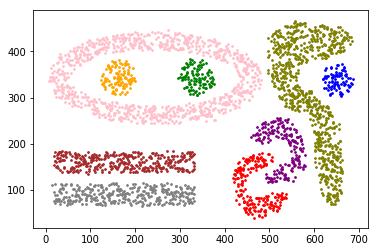

In [8]:
visualize_clusters(df1, 'x', 'y', 'class')

In [9]:
train_df1 = df1[['x','y']]

# K-Means visualization

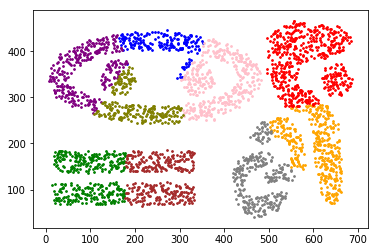

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9).fit(train_df1)
df1['k_means_predicted'] = kmeans.labels_
visualize_clusters(df1, 'x', 'y', 'k_means_predicted')

# DBScan visualization

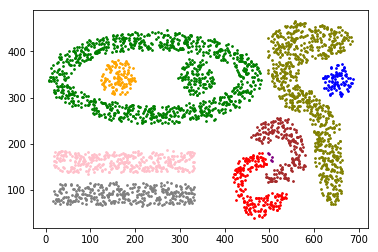

In [13]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=13, min_samples=5).fit(train_df1)
df1['db_scan_predicted'] = dbscan.labels_
visualize_clusters(df1, 'x', 'y', 'db_scan_predicted')

# Meanshift visualization

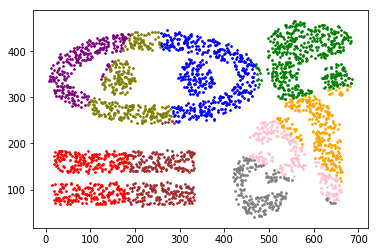

In [15]:
from sklearn.cluster import MeanShift

meanshift = MeanShift(bandwidth=80).fit(train_df1)
df1['mean_shift_predicted'] = meanshift.labels_
visualize_clusters(df1, 'x','y', 'mean_shift_predicted')

In [31]:
from sklearn import metrics
k_means = np.array(df1['k_means_predicted'])
db_scan = np.array(df1['db_scan_predicted'])
meanshift = np.array(df1['mean_shift_predicted'])

In [94]:
def visualize_metrics(array, label):
    # set width of bar
    barWidth = 0.25

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    plt.bar(r1, array, color=['#7f6d5f', '#557f2d', '#2d7f5e'], width=barWidth, edgecolor='white', label=label)
    plt.xticks([r for r in range(len(bars1))], ['K-Means', 'DBSCAN', 'MeanShift'])

    # Create legend & Show graphic
    plt.legend()
    plt.show()

---

# Metriky vyhodnocovania

-----

## Zalozene na principe ze musia poznat 'ground truth', cize triedu do ktorej patria.

## Rand Score
Is a measure of the similarity between two data clusterings

- TP (True Positive): The object belongs to class positive and we classified it as positive,
- FP (False Positive ): The object belongs to class negative and we classified it as positive,
- TN (True Negative): The object belongs to class negative and we classified it as negative,
- FN (False Negative): The object belongs to class positive but we classified it as negativ


## (TP + TN) / (TP + FP + TN + FN)

---

## Vyhodnotenue podla davies bouldin
#### Intuícia
- Sú dobre rozdelené od seba
- Sú dobre nahustené
- Vyberáme vždy bod ktorého priemer je najvzdialenejší od centroidu.


In [108]:
from sklearn.metrics import davies_bouldin_score

dbs_mean_k_means = metrics.davies_bouldin_score(np.array(train_df1), k_means)
dbs_mean_db_scan = metrics.davies_bouldin_score(np.array(train_df1), db_scan)
dbs_db_meanshift = metrics.davies_bouldin_score(np.array(train_df1), meanshift)

/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


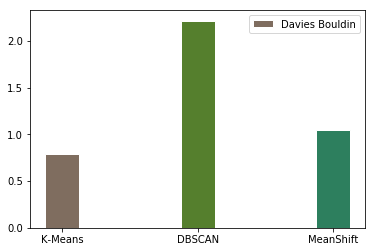

In [109]:
visualize_metrics([dbs_mean_k_means, dbs_mean_db_scan, dbs_db_meanshift], 'Davies Bouldin')

#### Mensi koeficient, znamena ze algoritmus lepsie separuje klustery.
#### Index sa vypocita ako podobnost priemeru dvoch clusterov

- The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained from DBSCAN.


---

## Nasleduje vyhodnotenie podla silhouete coeficientu

Vyhodnocuje sa ako dobre je každý jednotlivec clusteru priradený doňho zaradený.

+ a(i) - priemerná vzdialenosť bodu i od všetkych bodov klusteru do ktorého patrí bod i.
+ b(i) - je najmenší priemer vzdialenosti bodu i ku každému bodu v iných clusteroch. Robí sa to tak že zoberieme urobíme priemer bodu i ku každému bodu v clusteri A, potom clusteri B a ich výsledky porovnáme.

### 3 prípady:
#### - S(i) sa bliži k 0 - nevieme presne povedat, nachadza sa medzi dvoma clusterami
#### - S(i) sa blíži k -1 - lepsie by bolo ak by sme ho prehodili do ineho clusteru
#### - S(i) sa blíži k 1 - bod je dobre priradeny
Veľmy dobrá metrika, ale časovo náročná O(nˆ2),

- (b - a)/max(a,b)

In [110]:
from sklearn.metrics import pairwise_distances

pd_mean_k_means = metrics.silhouette_score(np.array(train_df1), k_means)
pd_mean_db_scan = metrics.silhouette_score(np.array(train_df1), db_scan)
pd_mean_meanshift = metrics.silhouette_score(np.array(train_df1), meanshift)

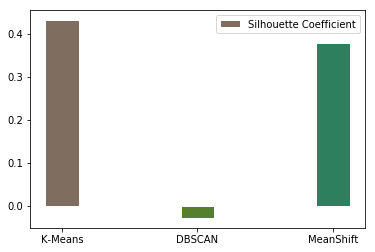

In [111]:
visualize_metrics([pd_mean_k_means, pd_mean_db_scan, pd_mean_meanshift], 'Silhouette Coefficient')

---

## Vyzualizacia vyhodnotenia

In [75]:
from sklearn.metrics.cluster import contingency_matrix

cm_kmeans = contingency_matrix(k_means, db_scan)

In [79]:
cm_kmeans

array([[  0,   0,   1, 193,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 112,   0,   0, 281],
       [  2,   0,   0,   0,   0,   0,   0, 182, 168,   0],
       [  2,  85,   0,   0,   0,   0,   0,   0,   0, 461],
       [  0,   0,  53, 258,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 161, 158,   0],
       [  0,   0,   0, 385,   0,   0,   0,   0,   0,   0],
       [  2,   0,   0,   0, 198,   5,  85,   0,   0,   0],
       [  0,   0,  59, 180,   0,   0,   0,   0,   0,   0]])

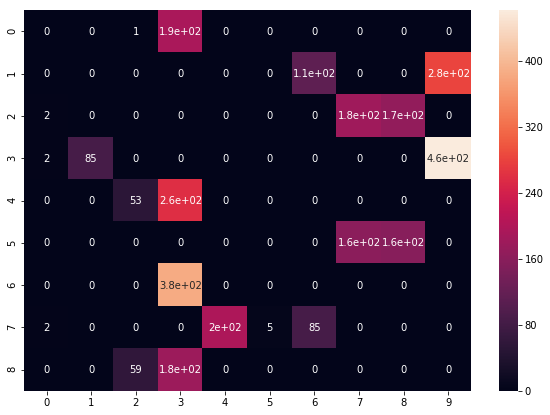

In [77]:
import seaborn as sn

df_cm = pd.DataFrame(cm_kmeans)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm)